In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# from transformers import Trainer, TrainingArguments
# import torch

# model = AutoModelForCausalLM.from_pretrained("gpt2")
# tokenizer = AutoTokenizer.from_pretrained("gpt2")

# prompt = "Her birthday is on the 9th."

# input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# gen_tokens = model.generate(
#     input_ids,
#     do_sample=True,
#     temperature=0.9,
#     max_length=100,
# )
# gen_text = tokenizer.batch_decode(gen_tokens)[0]
# print(gen_text)

In [1]:
from google.colab import drive
drive.mount("Mydrive")

Mounted at Mydrive


In [ ]:
import os
import torch
import random
from tqdm import tqdm
from IPython.display import clear_output

if not (os.path.exists('/content/ijcnlp_dailydialog.zip') and os.path.exists('/content/ijcnlp_dailydialog')):
  print('dowloading...')
  !wget http://yanran.li/files/ijcnlp_dailydialog.zip
  !unzip /content/ijcnlp_dailydialog.zip
else:
  print('files already exists')

if not (os.path.exists('/content/data/test') and os.path.exists('/content/data/train') and os.path.exists('/content/data/validation')):
  !mkdir data
  !unzip /content/ijcnlp_dailydialog/validation.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/train.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/test.zip -d /content/data
else:
  print('files already exists')

!rm /content/ijcnlp_dailydialog.zip
!rm -r /content/ijcnlp_dailydialog

clear_output(wait=False)

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace  # Correct import for Whitespace
from tokenizers.trainers import WordLevelTrainer

# Path to the dataset
path = "/content/data/train/dialogues_train.txt"
validation_path = "/content/data/validation/dialogues_validation.txt"
# Initialize the tokenizer with the WordLevel model
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()  # Ensure it tokenizes on whitespace

# Define the trainer with the specification for special tokens
trainer = WordLevelTrainer(special_tokens=["[UNK]"])

# Train the tokenizer
tokenizer.train(files=[path], trainer=trainer)
vocabsize = tokenizer.get_vocab_size()

print("Vocabulary size:", vocabsize)

# Test decoding some tokens
print(tokenizer.decode([1, 2, 3, 4, 5, 6]))

Vocabulary size: 20691
. __eou__ , I you ?


In [ ]:
class CustomDataset():

    def __init__(self, data_path, tokenizer, batchsize, maxlength) -> None:
        self.data = open(data_path)
        self.tokenizer = tokenizer
        self.batchsize = batchsize
        self.maxlength = maxlength
        self.data = self.custom_dataset()


    def custom_dataset(self):
        data = []
        for line in self.data:
            seqs = line.split('__eou__')
            seqs = ''.join(seqs)
            data.append(seqs)
        self.length = len(data)//self.batchsize
        return data


    def __len__(self):
        return self.length


    def batch_tokenize(self, texts):
        token_ids_batch, token_mask_batch = [], []
        # add start token
        for text in texts:
            encoded = self.tokenizer.encode(text)
            if len(encoded) >= 64:
                token_ids_batch.append(encoded.ids)
                token_mask_batch.append(encoded.attention_mask)

        # Pad the sequences
        padded_ids_batch = [
            ids if len(ids) < self.maxlength else ids[:self.maxlength]
            for ids in token_ids_batch
        ]
        # Pad the masks
        padded_mask_batch = [
            mask if len(mask) < self.maxlength else mask[:self.maxlength]
            for mask in token_mask_batch
        ]
        return torch.tensor(padded_ids_batch), torch.tensor(padded_mask_batch)


    def load_batch(self, shuffle=True):
        data = self.custom_dataset()
        if shuffle:
            random.shuffle(data)

        for i in range(0, len(data), self.batchsize):

            batch_texts = data[i:i+self.batchsize]
            yield self.batch_tokenize(batch_texts)


dataset = CustomDataset(path, tokenizer, batchsize=64, maxlength=64)

In [ ]:
import torch
import torch.nn as nn
import math

import torch.nn.functional as F

from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, d_model, vocab_size, max_lens, device="cuda", dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout_layer = nn.Dropout(dropout)
        self.embedding_layer = nn.Embedding(vocab_size, d_model)
        self.positional_enoc = nn.Parameter(torch.zeros(1, max_lens, d_model)).to(device)

    def forward(self, x):
        embedding = self.layer_norm(self.embedding_layer(x))
        return self.dropout_layer(embedding + self.positional_enoc[:, :x.size(1), :])


class Vanilla_Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens, device="cuda", dropout=0.1) -> None:
        super().__init__()
        self.embedding_layer = EmbeddingLayer(d_model, vocab_size, max_lens, device)
        encoder_layer = TransformerEncoderLayer(d_model, n_head, dim_feedforward, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout_layer = nn.Dropout(dropout)
        self.device = device

    def get_causal_mask(self, seq_len, device):
        return Transformer.generate_square_subsequent_mask(sz=seq_len, device=device)

    def forward(self, x, src_padding_mask=None):
        embedding = self.embedding_layer(x)
        mask = self.get_causal_mask(x.size(1), device=self.device)
        encoded_embedding = self.encoder(src=embedding, mask=mask,
                          src_key_padding_mask=src_padding_mask, is_causal=True)
        output = self.output_layer(encoded_embedding)
        return self.dropout_layer(output)

In [ ]:
src = torch.tensor([[0, 1, 2, 3, 4]]).to(device)
tgt = torch.tensor([[1, 2, 3, 4, 5]]).to(device)

vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens = vocabsize, 512, 8, 2048, 4, 64
teacher_model = Vanilla_Transformer(vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens).to(device)

pretrained_state_dict = torch.load("/content/model")
teacher_model.load_state_dict(pretrained_state_dict)

teacher_model.eval()

# vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens = vocabsize, 256, 4, 1024, 1, 64
vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens = vocabsize, 512, 8, 2048, 2, 64
student_model = Vanilla_Transformer(vocab_size, d_model, n_head, dim_feedforward, num_layers, max_lens).to(device)

In [ ]:
perplexity = []
def calculate_perplexity(validation_loss):
    return math.exp(validation_loss)

def validation(model, dataset, criterion):
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for token_ids, token_masks in tqdm(dataset.load_batch(), total=dataset.length, leave=False):
            tokens = token_ids.to(device)
            masks = token_masks.to(device)
            for j in range(2):
                src = tokens[:, j*31:(j+1)*31]
                tgt = tokens[:, j*31+1:(j+1)*31+1]
                output = model(src)
                loss = criterion(output.transpose(1,2), tgt)
                epoch_loss += loss.item()
        epoch_loss = epoch_loss/(dataset.length*2)
        plerplexity_score = calculate_perplexity(epoch_loss)
        perplexity.append(plerplexity_score)
    return epoch_loss, plerplexity_score

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def distillation_loss(student_logits, teacher_logits, temperature=1.2):
    student_probs = torch.nn.functional.softmax(student_logits / temperature, dim=-1)
    teacher_probs = torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    return torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')

epoch = 80
step_size = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-3)
dataset = CustomDataset(path, tokenizer, batchsize=64, maxlength=64)
validationset = CustomDataset(validation_path, tokenizer, batchsize=32, maxlength=64)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, threshold=0.001)
# please exploring these parameters: epoch, lr, scheduler(step_size, gamma), (num_layer, d_model, n_head, dim_feedforward), batch_size
# size of (num_layer=6, d_model=512, n_head=8, dim_feedforward=2048)->153 MB, please don't test model larger than this one
train_loss = []
valid_loss = []
for i in range(epoch):
    e_primary_loss = 0
    e_distill_loss = 0
    student_model.train()
    teacher_model.eval()
    for token_ids, token_masks in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
        tokens = token_ids.to(device)
        masks = token_masks.to(device)

        for j in range(2):
            optimizer.zero_grad()
            src = tokens[:, j*31:(j+1)*31]
            tgt = tokens[:, j*31+1:(j+1)*31+1]

            with torch.no_grad():
                teacher_logits = teacher_model(src)
            student_logits = student_model(src)
            primary_loss = criterion(student_logits.transpose(1, 2), tgt)
            distillation_losses = distillation_loss(student_logits, teacher_logits)
            loss = primary_loss + distillation_losses
            loss.backward()
            optimizer.step()
            e_primary_loss += primary_loss.item()
            e_distill_loss += distillation_losses.item()

    e_primary_loss = e_primary_loss/(dataset.length*2)
    e_distill_loss = e_distill_loss/(dataset.length*2)
    v_loss, plerplexity_score = validation(student_model, validationset, criterion)
    print("Primary loss", e_primary_loss)
    print("Distill loss", e_distill_loss*1.2)
    print(v_loss)
    print("Perplexity:", plerplexity_score)
    # print(tgt[0])
    # print(torch.argmax(output, dim=-1)[0])
    print('tgts: {}'.format(tokenizer.decode(tgt[0].tolist())))
    print('pred: {}'.format(tokenizer.decode(torch.argmax(student_logits, dim=-1)[0].tolist())))
    print("epoch: {}".format(i))
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {i + 1}, Current Learning Rate: {current_lr}")
    train_loss.append(e_primary_loss+e_distill_loss)
    valid_loss.append(v_loss)
    scheduler.step(v_loss)
    #     optimizer.zero_grad()
    #     with torch.no_grad():
    #         teacher_logits = teacher_model(tokens)
    #     student_logits = student_model(tokens)
    #     primary_loss = criterion(student_logits.transpose(1, 2), tokens[:, :])
    #     distillation_losses = distillation_loss(student_logits, teacher_logits)
    #     loss = primary_loss + distillation_losses
    #     loss.backward()
    #     optimizer.step()
    #     e_loss += loss.item()
    # e_loss = e_loss / dataset.length
    # v_loss = validation(student_model, validationset, criterion)
    # print(e_loss)
    # print(v_loss)
    # print("epoch: {}".format(i))
    # current_lr = optimizer.param_groups[0]['lr']
    # print(f"Epoch {i + 1}, Current Learning Rate: {current_lr}")
    # train_loss.append(e_loss)
    # valid_loss.append(v_loss)
    # scheduler.step(v_loss)

174it [00:15, 11.03it/s]                         


Primary loss 5.128836575271078
Distill loss 134.5884664899352
4.229541874700977
Perplexity: 68.68575828135245
tgts: and then paint the walls , we will get paint all over our new floor . Hmm Maybe you ' re right . But I can ' t stand all this
pred: I a the . traffic . I ' have the . the the company car . I . you ' re right . I we can ' t . that the
epoch: 0
Epoch 1, Current Learning Rate: 0.001


174it [00:15, 10.99it/s]                         


Primary loss 4.446519301805882
Distill loss 110.60789271007383
4.049473650993839
Perplexity: 57.367253900369164
tgts: heard he ' s very clear about his likes and dislikes and he ' s not the type to just let things go , so don ’ t provoke him .
pred: ' you ' s very well . David new to he . a ' ll very in new of me a me . . but I ' t know a .
epoch: 1
Epoch 2, Current Learning Rate: 0.001


174it [00:15, 11.03it/s]                         


Primary loss 4.1150959027295855
Distill loss 99.78884608979858
4.007407219179215
Perplexity: 55.004072017802834
tgts: . Is there anything special they would like to do ? They would like to visit our factory and have a look at the new type computer products . Besides ,
pred: in I that anything else ? ? like to go for I ' like to go a products . have a lot at the wedding place . . . What ...
epoch: 2
Epoch 3, Current Learning Rate: 0.001


174it [00:15, 10.98it/s]


Primary loss 3.8558718724057854
Distill loss 91.60131207063708
3.964053015555105
Perplexity: 52.67036774637385
tgts: all over . Are you coughing much ? A little bit . Now , let me listen to your chest . Ah , you have a temperature . Breathe deeply .
pred: all day . I you serious ? ? Yes few bit . I , I me see to the weaknesses hurts Breathe , yes sure a look , Breathe deeply .
epoch: 3
Epoch 4, Current Learning Rate: 0.001


174it [00:15, 11.03it/s]                         


Primary loss 3.6419704904446024
Distill loss 85.15403401810309
3.9530732131773427
Perplexity: 52.09522079539383
tgts: in the car . Did you get the camera ? Got it ! Did you fill up the tank ? Yup , it ’ s all set . You ’ re
pred: a the bag . It you like any bag ? No it was I you have out . tank ? No , I was s too right the I can re
epoch: 4
Epoch 5, Current Learning Rate: 0.001


174it [00:15, 11.01it/s]


Primary loss 3.469433456487049
Distill loss 80.09045369583747
3.9264586971652125
Perplexity: 50.72701947616924
tgts: the weather usually like this here ? It ' s usually a bit hotter than today . What ' s the weather like in winter ? It ' s pretty cold
pred: this office like this this evening in Yes ' s not only long hotter . this . It do s the weather forecast ? the ? It ' s mild cold
epoch: 5
Epoch 6, Current Learning Rate: 0.001


174it [00:15, 11.03it/s]


Primary loss 3.326793058759215
Distill loss 76.10147791956202
3.9097215514029227
Perplexity: 49.88505961447893
tgts: a look at it for me ? No sweat . It ’ s a piece of cake . Are you sure ? Absolutely . I ’ m a great mechanic .
pred: you bus for the ? a . It , . It ' s 3 great of you . I you sure you Yes , I ’ m not look . .
epoch: 6
Epoch 7, Current Learning Rate: 0.001


174it [00:15, 10.97it/s]                         


Primary loss 3.2079157973989587
Distill loss 72.88790118708087
3.8707381140801216
Perplexity: 47.97778609403703
tgts: right . Come on , speed up ! Geez ! What ’ s the rush ? Don ’ t worry about it , just drive . Oh , no , the
pred: nuclear . I in , please up . Geez , Don ' s the rush ? I ’ t worry about it ! maybe like , I , don . I
epoch: 7
Epoch 8, Current Learning Rate: 0.001


174it [00:15, 11.02it/s]                         


Primary loss 3.1181083290563154
Distill loss 70.45714878236627
3.890277874085211
Perplexity: 48.92447948005922
tgts: He ' s still here . He ' s going to move tomorrow . When ? Tomorrow morning ? No . Tomorrow afternoon . I ' ll miss him . He
pred: I does s not a . He ' s still to be tomorrow morning He he He morning . Tomorrow . He morning . I ' m be him . I
epoch: 8
Epoch 9, Current Learning Rate: 0.001


174it [00:15, 11.02it/s]


Primary loss 3.034788778062501
Distill loss 68.32177733051984
3.889786389566237
Perplexity: 48.900439763853996
tgts: venues . Why , what ' s the lowdown ? According to the report , our Boston crowd is quite different make - up from our Chicago folks . Our Boston
pred: a . Do don Jerry is s that lowdown ? You to the lowdown ? the company crowd and that fresh from a up . our Chicago folks , I company
epoch: 9
Epoch 10, Current Learning Rate: 0.001


174it [00:15, 11.01it/s]                         


Primary loss 2.9691629540713538
Distill loss 66.57541703240719
3.869874527377467
Perplexity: 47.936371001278985
tgts: about that ? Our meeting was proponed until Friday . What ? The meeting was proponed ? No one told me anything about it . Didn ' t you get the
pred: the the . The new is proponed . Friday . I happened It meeting is proponed ? It , of me is about this was I ' t you think off
epoch: 10
Epoch 11, Current Learning Rate: 0.001


174it [00:15, 11.03it/s]                         


Primary loss 2.907990903523616
Distill loss 65.04587827032012
3.8901554307629986
Perplexity: 48.91848937098607
tgts: ’ s start with the basics , bread . Bread is an important ingredient here . You need to remember one thing - choose the bread according to the following criteria
pred: ' s cross to to basics tonight shall . Bread , a order ingredient here . I ’ to make to - so bedroom from goods . to the following criteria
epoch: 11
Epoch 12, Current Learning Rate: 0.001


174it [00:15, 11.05it/s]


Primary loss 2.8549075925970353
Distill loss 63.76485324043759
3.892089366912842
Perplexity: 49.01318614521914
tgts: couple of different options such as beaches , the wilderness , the countryside or even going to a spa for the weekend . I think something in the countryside would be
pred: bird of weeks options such as beaches , the wilderness , the countryside countryside are going to be spa for a weekend . I think you . the countryside have be
epoch: 12
Epoch 13, Current Learning Rate: 0.001


174it [00:15, 11.00it/s]                         


Primary loss 2.8094085062170304
Distill loss 62.64490434503279
3.870253462945261
Perplexity: 47.95453923932075
tgts: package includes air travel to and from Paris , accommodations , meals and transportation around the city . How long is the tour ? print ( md5 ( this_is_a_test_string ) );
pred: bridegroom is two . quality the I the , which , and . transportation around the USA , From much have it tour ? It ( this_is_a_test_string to this_is_a_test_string ) );
epoch: 13
Epoch 14, Current Learning Rate: 0.001


174it [00:15, 11.00it/s]


Primary loss 2.5705251266501543
Distill loss 56.25638814496167
3.7805713030599777
Perplexity: 43.841081126152794
tgts: or non ? Non - smoking is fine , thank you . Right , this way , please . Something to drink first ? Just water , please . Wold you
pred: or non ? Non - smoking is done . please you . I over thank is , please . I to drink , ? I take , please . Wold you
epoch: 14
Epoch 15, Current Learning Rate: 0.0002


174it [00:15, 11.01it/s]                         


Primary loss 2.4904048470403417
Distill loss 54.029776111227925
3.7789119328221967
Perplexity: 43.768392865986684
tgts: tough team . Sure they are . Who ' s winning ? We are , 27 to 26 . Really ? I thought that they ' d been killing us by
pred: lot day . But , are . They ' s winning ? They ' , 27 to 26 . They going We think they they ' re like killing us by
epoch: 15
Epoch 16, Current Learning Rate: 0.0002


174it [00:15, 10.99it/s]


Primary loss 2.441316847856334
Distill loss 52.799589468013345
3.7771512539156022
Perplexity: 43.69139858088897
tgts: . Thomas left the office a few minutes ago . That ' s bad ! I ' ve been trying to call him for the last ten minutes , but your
pred: . : , it office with seat minutes . . I ’ s a . I ' ve been looking to call you for a last ten days , but I
epoch: 16
Epoch 17, Current Learning Rate: 0.0002


174it [00:15, 11.03it/s]                         


Primary loss 2.40994300869848
Distill loss 52.15077589178361
3.7695517962978733
Perplexity: 43.36062608677876
tgts: tickets for the matinee . It starts at 3p . m . Ok . I ’ ll take it . Where would you like to sit ? Do you have anything
pred: a for this matinee . Would is at 3p . What sorry What . What ’ ll take it . Thanks do you be the go ? It you want to
epoch: 17
Epoch 18, Current Learning Rate: 0.0002


174it [00:15, 11.02it/s]                         


Primary loss 2.38984297913623
Distill loss 51.65318630416959
3.7930187948288454
Perplexity: 44.39020312834575
tgts: you prefer crisps ? Oh , just olives please . What music is this ? Do you like it ? It ' s Irish music . It ' s great !
pred: like like crisps ? No , that olives olives . I ’ do it ? It I have it ? Yes ' s Irish music . It ' s Irish .
epoch: 18
Epoch 19, Current Learning Rate: 0.0002


174it [00:15, 11.06it/s]


Primary loss 2.3664310323020628
Distill loss 51.14732110348739
3.76871007873166
Perplexity: 43.32414404206237
tgts: disappointed with it . How come ? It ’ s too old . And it isn ’ t as specious as I expected . Oh . It ’ s awful ,
pred: disappointed with it . It come ? It ’ s too old . And it isn ’ t as specious as I ’ . And . Oh ’ ll awful ,
epoch: 19
Epoch 20, Current Learning Rate: 0.0002


174it [00:15, 10.99it/s]


Primary loss 2.349667913307344
Distill loss 50.798724898850985
3.768796105538645
Perplexity: 43.32787124015685
tgts: politician . He was born in 1911 and died in 1985 . Very good . Sit down , please . Susan , what ' s the general idea of the text
pred: good . I ' the in 1911 and died in the . And well . I down , please . When , what time s the text impression , the text
epoch: 20
Epoch 21, Current Learning Rate: 0.0002


174it [00:15, 10.93it/s]                         


Primary loss 2.328771529859201
Distill loss 50.3288322492831
3.7643933911477365
Perplexity: 43.13753031375058
tgts: . How much does each copy cost ? Each copy will cost you a dime , sir . A dime ? I remember when copies used to cost a nickel .
pred: morning What can do this copy cost ? Each copy is cost you only dime , 000 . We dime ? A ' when copies used to cost a dime .
epoch: 21
Epoch 22, Current Learning Rate: 0.0002


174it [00:15, 11.01it/s]                         


Primary loss 2.317753172334219
Distill loss 50.011567798239646
3.8266639209562734
Perplexity: 45.90912600565328
tgts: they are old - fashioned people from the Chinese countryside . That ’ s their custom . I know , but it is hard for me to get used to your
pred: I overcharge old - fashioned people from the Chinese countryside . That ’ s right custom . I know , the it ' hard for me to find used to describe
epoch: 22
Epoch 23, Current Learning Rate: 0.0002


174it [00:15, 11.02it/s]


Primary loss 2.304750915207615
Distill loss 49.895455870876425
3.813252314444511
Perplexity: 45.297521340399506
tgts: use the machine . How much does it cost ? We charge ten cents a copy . How many copies am I allowed to make ? There is no limit to
pred: go the . . I many do it cost ? $ charge ten cents a copy . I much copies ? , allowed to pay per It is a limit to
epoch: 23
Epoch 24, Current Learning Rate: 0.0002


174it [00:15, 10.99it/s]


Primary loss 2.2880606585844405
Distill loss 49.55162351751603
3.77872512802001
Perplexity: 43.76021748363943
tgts: to know where this relationship is going . I ’ m in love with you and I need to know ... You know , I think you ’ re awesome .
pred: to go about this relationship is going . You want m in love with my . I don to get where I know , I know we ’ re awesome .
epoch: 24
Epoch 25, Current Learning Rate: 0.0002


174it [00:15, 10.99it/s]                         


Primary loss 2.281684840345658
Distill loss 49.35279086338991
3.798584703476198
Perplexity: 44.63796381083662
tgts: you stood me up on the Valentine ' s Day . I ' m very sorry for that , but I sent you several messages to explain , my mom was
pred: I ' me up on a Valentine ' s Day . I really m very sorry to that . but I didn you two messages to hear , I job said
epoch: 25
Epoch 26, Current Learning Rate: 0.0002


174it [00:15, 11.02it/s]                         


Primary loss 2.2668867366162337
Distill loss 49.1732643259743
3.780069285823453
Perplexity: 43.81907767127851
tgts: you ' re pretty bored too . Just killing time until I find something to do . What are you going to do ? It ' s Saturday and we are
pred: ? ' re going bored . . I a me to the ' a in get . I ' you going to do ? I ' s going and I '
epoch: 26
Epoch 27, Current Learning Rate: 0.0002


174it [00:15, 11.00it/s]


Primary loss 2.256848995051632
Distill loss 48.905869006559335
3.782051774763292
Perplexity: 43.90603467528478
tgts: yet . I ' d like to take English . Why are you going to take english with chemistry and physics ? Because I want to study english literature . but
pred: yet . I have m like to take English . Do don we going to take english with chemistry and physics ? Because I ' to study english with . Do
epoch: 27
Epoch 28, Current Learning Rate: 0.0002


174it [00:15, 11.02it/s]                         


Primary loss 2.2079216445112504
Distill loss 47.812951810098106
3.768178901364726
Perplexity: 43.30113734816394
tgts: come to our factory ? They are working in another factory to provide maintenance right now . Let me call them and see whether they have solved the problem . Please
pred: ? to our factory ? We are working in the factory to provide maintenance of now . I me ask them and see . they are solved the factory . We
epoch: 28
Epoch 29, Current Learning Rate: 4e-05


174it [00:15, 11.04it/s]                         


Primary loss 2.1997470990081744
Distill loss 47.60758926303401
3.770915127569629
Perplexity: 43.41978129919875
tgts: Is it difficult to learn ? Yes . The language is hard to learn , but it ' s interesting . Do you know anything about Britain and America ? I
pred: I there urgent to learn ? Yes , I language is hard to learn , but it ' t interesting . Do you think what about Britain and children ? Yes
epoch: 29
Epoch 30, Current Learning Rate: 4e-05


174it [00:15, 11.01it/s]


Primary loss 2.1997636628977824
Distill loss 47.62278844579796
3.791960266328627
Perplexity: 44.34323969365611
tgts: it . It ' s my pleasure . Have you been to one of these large , sit - down dinner parties since you got to New Haven ? No ,
pred: it . It ' s my pleasure . I you been to one more these shows , sit - down dinner parties since you got to New Haven ? No ,
epoch: 30
Epoch 31, Current Learning Rate: 4e-05


174it [00:15, 11.01it/s]


Primary loss 2.191265986833958
Distill loss 47.35680990494745
3.7636834306101643
Perplexity: 43.10691523857305
tgts: want to have a try . You are asking the right person . Here are two very important tips . First , you need to visit no more than one site
pred: ' to get a foot . What can a me right person for What are two designs important tips . Thank , you should to keep to more than one .
epoch: 31
Epoch 32, Current Learning Rate: 4e-05


174it [00:15, 10.96it/s]                         


Primary loss 2.1927047788752296
Distill loss 47.47866217552582
3.770108949753546
Perplexity: 43.38479134069539
tgts: over . Do you know where it measured on the Richter scale ? I don ' t remember , but it wasn ' t very serious . Have you ever been
pred: over , I you want where that measured on the Richter scale ? It don ' t know , but it wasn ' t very serious . I you got been
epoch: 32
Epoch 33, Current Learning Rate: 4e-05


174it [00:15, 11.02it/s]                         


Primary loss 2.1840641054114855
Distill loss 47.203933482087415
3.800193998121446
Perplexity: 44.70985728034393
tgts: you . Which country do you want to go to ? My field is electronic engineering . Which country do you think I should go ? Were I in your position
pred: Tianjin . What country do you want to go to ? I field is best engineering . Which country do they want I ' go ? Were I in your country
epoch: 33
Epoch 34, Current Learning Rate: 4e-05


174it [00:15, 10.98it/s]


Primary loss 2.179913238293863
Distill loss 47.19103663891037
3.7446268989193823
Perplexity: 42.293224626958725
tgts: . You must have a lot of pleasure in planting flowers . Yes , you are right . I love flowers and hence have taken to growing them . I take
pred: . I must have a lot of new in planting flowers . Yes , I are right . But know them and hence have been to growing them . I am
epoch: 34
Epoch 35, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.02it/s]


Primary loss 2.171363532887718
Distill loss 46.95376309521625
3.779211748030878
Perplexity: 43.78151726317606
tgts: wanted in this position , you must prepare to travel aboard frequently . That ' s fine with me . Would you mind relocating ? As long as it isn '
pred: you in this position , but know prepare to travel aboard frequently . I ' s good with me . You you like relocating ? Yes long have I ' '
epoch: 35
Epoch 36, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.00it/s]                         


Primary loss 2.170581277739795
Distill loss 47.0096334821227
3.7528788889608076
Perplexity: 42.643671850248836
tgts: . That ' s a little less than I expected . But to me , the most important thing is the job and the people I will work with . Moreover
pred: . I ' s why little less than a expected . I I have , I job of thing is the people . the job who expected do with the Moreover
epoch: 36
Epoch 37, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.00it/s]                         


Primary loss 2.1682161234017743
Distill loss 46.98921679899182
3.7693360159474034
Perplexity: 43.35127072507307
tgts: d like to call in to discuss the project plan . All right . What time are you coming ? Well , my flight leaves at 8 a . m .
pred: s like to send this . discuss the conference meeting . All right . All time does you coming ? I , I business leaves at 8 a . When .
epoch: 37
Epoch 38, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.05it/s]                         


Primary loss 2.165093916344505
Distill loss 46.816344385753474
3.7301394324148855
Perplexity: 41.68491998789978
tgts: a low fever . I feel terrible . Am I dying ? Certainly not . Take one of these white pills three times a day . Before the meals or after
pred: I course salaries . I ’ terrible . I I dying ? Yes not . I a of the three pills three times a day . Do I meals or after
epoch: 38
Epoch 39, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 10.99it/s]


Primary loss 2.1710190828135936
Distill loss 46.99830144981428
3.77225596674027
Perplexity: 43.47803929131604
tgts: please . Would you like anything to drink ? I ' ll have a tomato juice and some iced tea . Anything else ? Could I have a slice of pumpkin
pred: I . Here this like to to drink , No ' d have a tomato juice and some iced tea . How special ? No you have a slice of pumpkin
epoch: 39
Epoch 40, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.03it/s]                         


Primary loss 2.169618902867929
Distill loss 46.947170702983875
3.771420386529738
Perplexity: 43.44172507592422
tgts: m sorry . Mr . Li is in a meeting right now . Can I take a message ? Sure . This is Nigel Smith his personal banker . Could you
pred: s sorry . I ' Li is in a meeting right now . I you help a message ? Yes . I is Nigel Smith here personal banker . He you
epoch: 40
Epoch 41, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 10.98it/s]                         


Primary loss 2.160189940405719
Distill loss 46.7190256813358
3.770602157039027
Perplexity: 43.40619431348088
tgts: ’ Ve got a few concerns about him , and the bottom line is , I don ’ t think he ’ s a good fit for our company . Okay
pred: ' m been a really concerns about him ! and the bottom line is , he don ' t think he ’ ll a good fit for our company . He
epoch: 41
Epoch 42, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 10.99it/s]                         


Primary loss 2.1641331962767363
Distill loss 46.84323286817253
3.7987174410973825
Perplexity: 44.643889341229084
tgts: card ? No , I don ’ t . I ' m a tourist . Then you need to register as a new patient . Can I have a look at
pred: card ? I , I don ' t like I ’ m a tourist . You I need to register for a new one . That I have a new at
epoch: 42
Epoch 43, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.02it/s]


Primary loss 2.1669342579869175
Distill loss 46.87341842651367
3.7530198750957364
Perplexity: 42.64968444055815
tgts: , please . Well , Mark Smith , who was the first president , founded the company in Ottawa in 1955 . It has 1 . 5 billion dollars in capital
pred: , and . I , I , , I was the company thing , founded the company in Ottawa in 1955 . And is been . That billion dollars in capital
epoch: 43
Epoch 44, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.03it/s]                         


Primary loss 2.15909786444868
Distill loss 46.702974595086424
3.7729331254959106
Perplexity: 43.50749079684726
tgts: I advise that step be taken in power supply first . What ' s his suggestion for this work ? His suggestion is that the work be started at once .
pred: I think it step get a in power supply first . That ' s the suggestion for this work ? His suggestion is that movie first , ? at the .
epoch: 44
Epoch 45, Current Learning Rate: 8.000000000000001e-06


174it [00:15, 11.05it/s]


Primary loss 2.158703443287425
Distill loss 46.68395546709181
3.750530835120909
Perplexity: 42.543659675748884
tgts: tea , eggs and potatoes ? I forgot about the potatoes . Oh , I almost forget that we need a microwave oven badly . What kind of tea do you
pred: the eggs eggs and potatoes ? No ' about it potatoes . Then , yes ' forgot , we are for microwave oven badly ! That do of tea do you
epoch: 45
Epoch 46, Current Learning Rate: 1.6000000000000004e-06


174it [00:15, 11.02it/s]                         


Primary loss 2.1625822978901725
Distill loss 46.812499891953664
3.748606574150824
Perplexity: 42.461873286325215
tgts: , I have two cartons of cigarettes , one bottle of whisky . What ' s this white powder ? Are they drugs ? No , this is the medicine for
pred: , I ' a cartons of cigarettes , please bottle of whisky . Oh ' s the one ? ? It they drugs ? No , I is the medicine for
epoch: 46
Epoch 47, Current Learning Rate: 1.6000000000000004e-06


174it [00:15, 11.03it/s]                         


Primary loss 2.161976361205812
Distill loss 46.75661005009116
3.764585418085898
Perplexity: 43.14581467700159
tgts: then . Say it . Oh , really , Mark . I promise I ' m not going to be angry . Now why were you late ? I forgot .
pred: the . Say it . Oh , really , Mark . I promise I promise m not going to be angry . I why were you late ? I forgot .
epoch: 47
Epoch 48, Current Learning Rate: 1.6000000000000004e-06


174it [00:15, 10.98it/s]


Primary loss 2.1581811053904496
Distill loss 46.74369469791478
3.7661958932876587
Perplexity: 43.21535592379502
tgts: I ' ll ring to have a city tour . on sunday morning we can go to the Great Wall , then we can go to the summer palace in the
pred: I don m have and get the rest tour guide By sunday morning , ' go to the next Wall , right we can also to the beach palace in the
epoch: 48
Epoch 49, Current Learning Rate: 1.6000000000000004e-06


174it [00:15, 10.99it/s]


Primary loss 2.170327825008789
Distill loss 47.01458206617763
3.7438262816398375
Perplexity: 42.25937749162339
tgts: I should have it finished by Friday afternoon . Then I can check those account over the weekend . We need to have them finished by Monday , right ? that
pred: I ' not the finished by Friday morning . Then I will check those account over the weekend . That need to keep to finished by Monday , right ? You
epoch: 49
Epoch 50, Current Learning Rate: 1.6000000000000004e-06


174it [00:15, 10.99it/s]                         


Primary loss 2.1501336318220017
Distill loss 46.55565387527377
3.751359870356898
Perplexity: 42.578944492845416
tgts: little . If their neighbors have some resources , they try to steal them by military force . It seems that a lot of wars nowadays are really civil wars .
pred: , . I their neighbors have some problems , I try to steal them by military force . But seems that a lot of wars nowadays can really fun wars nowadays
epoch: 50
Epoch 51, Current Learning Rate: 1.6000000000000004e-06


174it [00:15, 10.99it/s]                         


Primary loss 2.155913540738166
Distill loss 46.53765694943466
3.7674525668544154
Perplexity: 43.2696976570208
tgts: How do you feel today ? I feel much better now . Have you received the reading material handed out yesterday ? I ’ Ve already got it . Thanks .
pred: I much you feel today ? I ' very better now . Have you received the reading material handed out yesterday , I ’ Ve been got it . I .
epoch: 51
Epoch 52, Current Learning Rate: 3.200000000000001e-07


174it [00:15, 11.02it/s]                         


Primary loss 2.159569517725465
Distill loss 46.69804926965967
3.7700143283413303
Perplexity: 43.38068640468053
tgts: for you . I ' m sorry but there aren ' t any direct flights available . Are there tickets for Saturday then ? Yes there are . How do you
pred: for the . Yes ' m sorry , I is ' t any problem one available . I you any ? seven then ? Yes , are only I about you
epoch: 52
Epoch 53, Current Learning Rate: 3.200000000000001e-07


174it [00:15, 11.00it/s]                         


Primary loss 2.163353372171435
Distill loss 46.839877764751456
3.7298320416481263
Perplexity: 41.67210839756557
tgts: was terrific . We toured the Three Gorges by boat . Its realty exciting ! Did your boat float down the river ? Yes . There are many places where the
pred: take terrific . Its toured the taxi Gorges by boat . Its realty exciting ! We you service float down the river ? Yes , We ' many places where the
epoch: 53
Epoch 54, Current Learning Rate: 3.200000000000001e-07


174it [00:15, 10.98it/s]


Primary loss 2.154278883355201
Distill loss 46.569198626038656
3.749073278519415
Perplexity: 42.481695053179315
tgts: three - piece suites on sale . Feel free to sit down and test how comfortable they are . I came to your store yesterday and have come back today to
pred: indoor - piece suites on sale . Feel free to sit down and test how comfortable they are . I came to your desk yesterday and have come back today to
epoch: 54
Epoch 55, Current Learning Rate: 3.200000000000001e-07


174it [00:16, 10.83it/s]


Primary loss 2.163118620828397
Distill loss 46.78027459293431
3.729073155310846
Perplexity: 41.640496000482266
tgts: No , I am afraid not . I just arrive in town today . Mr . Thomas is quite busy , I ’ m afraid he won ’ t be able
pred: I , it ' not not . I just arrive on town today . I . Thomas is quite busy , I am m afraid he won ’ t be able
epoch: 55
Epoch 56, Current Learning Rate: 3.200000000000001e-07


174it [00:16, 10.83it/s]                         


Primary loss 2.163478315221092
Distill loss 46.81581827505476
3.7764214661813553
Perplexity: 43.65952476608673
tgts: my parents ’ consent . Let me guess , your parents want you to marry a Chinese man , right ? You are right . It is giving me a real
pred: my traveler ’ consent . What me guess I your parents want you to marry a Chinese man , right ? Yeah ’ right . I is giving me to real
epoch: 56
Epoch 57, Current Learning Rate: 3.200000000000001e-07


174it [00:15, 10.99it/s]                         


Primary loss 2.1593930690274763
Distill loss 46.6864557563914
3.757272697264148
Perplexity: 42.83145220304588
tgts: under M . ( He looks through the Cds . ) Hmm , it looks like we ' ve sold out of that one , but we should be getting some
pred: and M ? Let He looks like the Cds . ) Hmm , it looks like you ' re sold out of that . hundred but we ' be getting some
epoch: 57
Epoch 58, Current Learning Rate: 6.400000000000003e-08


174it [00:15, 10.98it/s]


Primary loss 2.1514319422617123
Distill loss 46.5352561906583
3.7671193999628865
Perplexity: 43.2552840275604
tgts: OK , here it is . Let me take a look at this for you . May I have your driver ' s license , please ? Here ' s my
pred: I , I is is . It me see a look . the time you . It I see your name ' s license ? please ? Here ' s my
epoch: 58
Epoch 59, Current Learning Rate: 6.400000000000003e-08


174it [00:15, 11.02it/s]                         


Primary loss 2.1600121621451627
Distill loss 46.780739963950445
3.7460409710484166
Perplexity: 42.35307260185466
tgts: 00 sharp . It ' s a long way to go . If I take the shortest route , we may come across a traffic jam . If I take a
pred: 00 . . I ' s not long way to the . What you ' a shortest shortest , you can come back a break jam . I I take a
epoch: 59
Epoch 60, Current Learning Rate: 6.400000000000003e-08


174it [00:15, 10.98it/s]                         


Primary loss 2.1602896265900893
Distill loss 46.774306902582246
3.7631796521525227
Perplexity: 43.08520437249297
tgts: . It goes well with your skirt . Thank you . It ' s very nice of you to say so . Not at all . This dress certainly shows your
pred: . Yes ' on with your skirt , What ? . What ' s my popular of you . say so . I at all . I time really shows your
epoch: 60
Epoch 61, Current Learning Rate: 6.400000000000003e-08


174it [00:15, 10.99it/s]                         


Primary loss 2.161271070813857
Distill loss 46.71057398801594
3.769812353195683
Perplexity: 43.37192546900107
tgts: I have mine . Maybe you ' re right . But I just still can ' t understand ... Come on . I don ' t see any point in arguing
pred: I ' a . What you should re right . You I ' can have ' t make ... You on . You ' ' m know anything point in arguing
epoch: 61
Epoch 62, Current Learning Rate: 6.400000000000003e-08


174it [00:15, 11.02it/s]                         


Primary loss 2.1587682631663503
Distill loss 46.719376902497565
3.7605767019333376
Perplexity: 42.97320156243562
tgts: Tuesday and Thursday . And how long does the course last ? It lasts for 9 months . When does it start ? The next beginning class starts on October 25th
pred: please and Thursday . And how long does the course last ? It lasts for 9 months . When does it start ? The next week class starts on October 25th
epoch: 62
Epoch 63, Current Learning Rate: 6.400000000000003e-08


174it [00:15, 11.01it/s]                         


Primary loss 2.1605613224768225
Distill loss 46.81345653203181
3.7500610774563206
Perplexity: 42.523679158904464
tgts: ' t seen each other for years . It ' s been 3 years now . How time flies ! Now you are a college student out of a little girl
pred: ' t seen you other for years . How was s been really years now . How about flies , How it are a while student out of your year tired
epoch: 63
Epoch 64, Current Learning Rate: 1.2800000000000007e-08


174it [00:15, 11.01it/s]                         


Primary loss 2.155078580958306
Distill loss 46.59128290518171
3.7528707250472038
Perplexity: 42.643323712417185
tgts: you eat , the type of food you eat , and when you eat your meals . I never eat breakfast though . That ' s a big mistake , you
pred: easier eat for the food of food you eat , and when you eat your food . That never eat breakfast though . That ' s a big mistake , you
epoch: 64
Epoch 65, Current Learning Rate: 1.2800000000000007e-08


174it [00:15, 10.99it/s]


Primary loss 2.1574013984272247
Distill loss 46.639959516139385
3.7476160680094073
Perplexity: 42.419835362906674
tgts: on flight YW132 , is that right ? Yes , thanks . By the way , what time do I have to start check - in ? You are supposed to
pred: on flight YW132 , will that right ? Yes , here . I the train , what can will you do to do doing - in ? You can supposed to
epoch: 65
Epoch 66, Current Learning Rate: 1.2800000000000007e-08


174it [00:15, 11.03it/s]                         


Primary loss 2.1573710706881704
Distill loss 46.61958845722882
3.732259773438977
Perplexity: 41.773400004591316
tgts: - on our rights . And look out she ' s dressed . Yeah , I noticed . She must be really loaded . No way . Her old man is
pred: - on the rights . I it through she ' s dressed . She , it noticed . She must be really loaded . Her , . Her old man is
epoch: 66
Epoch 67, Current Learning Rate: 1.2800000000000007e-08


174it [00:15, 11.01it/s]


Primary loss 2.1549370147589313
Distill loss 46.646272877599465
3.7470298197961625
Perplexity: 42.39497409836703
tgts: for sexual harassment . What happened ? Did your boss say something to offend you at work ? He constantly lets inappropriate things slip out , referring to the women employees
pred: just sexual harassment . He happened ? I you boss say something . offend you . work ? He constantly lets inappropriate things slip out , referring to her time employees
epoch: 67
Epoch 68, Current Learning Rate: 1.2800000000000007e-08


174it [00:15, 11.02it/s]                         


Primary loss 2.161283038255107
Distill loss 46.780428512661445
3.7466765757529967
Perplexity: 42.38000097104633
tgts: Candlelight in the Window Should we go see it ? I ' d rather not . I don ' t like horror movies . How about ‘ Run of the Mill
pred: I in the Window Should we go there the ? I just m rather not . I again ' t think to movies . It about ‘ Run of the Mill
epoch: 68
Epoch 69, Current Learning Rate: 1.2800000000000007e-08


174it [00:15, 11.01it/s]


Primary loss 2.169398034239091
Distill loss 46.966903929076445
3.770798783148489
Perplexity: 43.41472994373167
tgts: week . Would you like to try one on ? No , thank you . I don ' t need any skirts . How about a blouse ? This one here
pred: morning . I you please to try one ? ? No , I you . I ' ' t like any skirts . How about this blouse would This one here
epoch: 69
Epoch 70, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 10.99it/s]                         


Primary loss 2.157995188511865
Distill loss 46.66366787067039
3.7896994775341404
Perplexity: 44.24310223172297
tgts: con order some typical Chinese dishes . For example , Roast Beijing Duck . It sounds good . Yes , it is the best of our hotel . Really ? Let
pred: don . some typical Chinese dishes . I example , Roast Beijing Duck . I ' great . What , it ' the best of the fish has I ? Yes
epoch: 70
Epoch 71, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 10.99it/s]                         


Primary loss 2.155789767042061
Distill loss 46.58834211757418
3.752343693087178
Perplexity: 42.62085523926082
tgts: They ' re saying it was already there . What the hell . That doesn ' t make sense . What are you going to do ? I have to go
pred: I wear re all that ' too . . I did hell . It ' ' t work sense . The ' they going on do ? I ' a go
epoch: 71
Epoch 72, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 11.03it/s]                         


Primary loss 2.1600017681976276
Distill loss 46.68998885843795
3.765360378449963
Perplexity: 43.17926393250113
tgts: eggs with bacon , toast and coffee . It will take about 20 minutes , sir . Is that all right ? Yes , it is . Oh , by the
pred: eggs with bacon , toast and coffee . What ' be a 20 minutes . sir . What there right right ? Yes , sir ' the Do , it the
epoch: 72
Epoch 73, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 11.03it/s]


Primary loss 2.155890855830529
Distill loss 46.599137177219276
3.7581904511297903
Perplexity: 42.8707789772655
tgts: . Thanks . I didn ' t know you smoked . Really ? I ' ve been smoking for over a year now . Oh . You ' re new to
pred: by What . I ' ' t know I smoked , But ? I ' m been having for a the year . . I dear You ' re right .
epoch: 73
Epoch 74, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 10.99it/s]


Primary loss 2.160707871693407
Distill loss 46.727958661559
3.7444224895969516
Perplexity: 42.28458038108164
tgts: There are no sales today . Are dresses going to be on sale ? Everything ' s going to be on sale next weekend . That ' s great . I
pred: It are so extra today . What dresses going to be on sale ? Yes ’ s going to be sure sale . weekend . I ' s the . I
epoch: 74
Epoch 75, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 11.02it/s]


Primary loss 2.160542270696232
Distill loss 46.75289197712275
3.778722440042803
Perplexity: 43.76009985733036
tgts: ' s salary was too low and got no promotion . Poor Kevin , we should do something for him . He is a nice guy and does his job well
pred: ' ll salary has too difficult and got no promotion . We Kevin does we should do something for him but Poor does a nice restaurant and does his salary well
epoch: 75
Epoch 76, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 11.01it/s]                         


Primary loss 2.1539481306351678
Distill loss 46.599328988135895
3.757482497922836
Perplexity: 42.840439212637925
tgts: the fish . Our special tonight is lobster . Thank you , but I prefer the fish . Perhaps you ' d enjoy the lamb . No , I ' d
pred: to fish . Our special tonight is lobster . Thank you , sir I prefer the fish . Perhaps you ' d enjoy the fish chops Perhaps , I ' d
epoch: 76
Epoch 77, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 11.03it/s]


Primary loss 2.157333232763875
Distill loss 46.69573420265506
3.7543144264528827
Perplexity: 42.70493240037755
tgts: a very big family . Do you all live together ? Of course we do ! My father ' s parents , Mum , Dad , three unmarried aunts , two
pred: fun very good family . I you like live in ? Not course , do . What parents is s parents , Mum , Mum , three unmarried aunts , Mum
epoch: 77
Epoch 78, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 11.00it/s]                         


Primary loss 2.1625498164595895
Distill loss 46.73776733310236
3.763448111472591
Perplexity: 43.09677254988685
tgts: me anything . We ’ re friends . Have you got a scholarship , or are you on your own ? I have a scholarship from my government for four years
pred: anyone questions . First can Ve going . What you got any scholarship in or a you interested your own ? I ’ , scholarship from my government for four years
epoch: 78
Epoch 79, Current Learning Rate: 2.5600000000000015e-09


174it [00:15, 11.01it/s]                         
                                               

Primary loss 2.1591229362983926
Distill loss 46.69284531698061
3.7804559315404584
Perplexity: 43.83602340576996
tgts: and I had good reason to believe that it was mine for the asking . So what happened ? We were awarded government funding last year and in order to keep
pred: . I ’ an reason to ask that it was mine for the asking . I what happened ? I went awarded last funding last few and we the to go
epoch: 79
Epoch 80, Current Learning Rate: 2.5600000000000015e-09


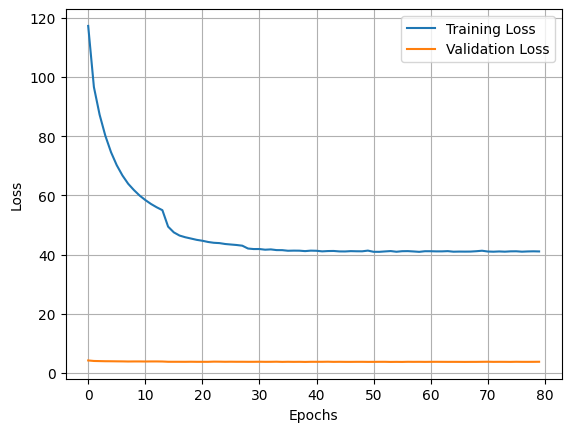

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True)

plt.legend()

plt.show()
plt.savefig('kd_loss_plot.jpg')



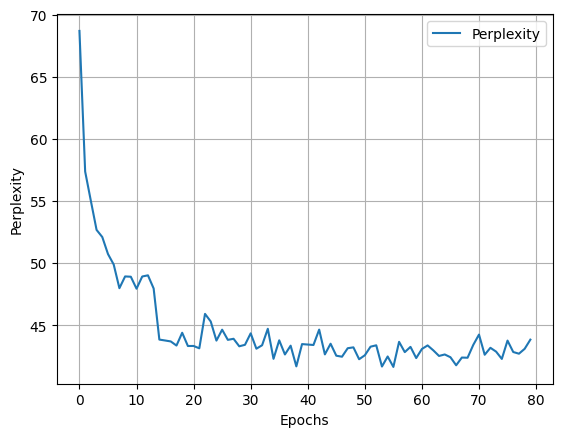

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(perplexity, label='Perplexity')

plt.xlabel('Epochs')
plt.ylabel('Perplexity')

plt.grid(True)

plt.legend()

plt.show()
plt.savefig('kd_perplexity_plot.jpg')

In [ ]:
torch.save(student_model.state_dict(), "/content/student_model")

In [ ]:
!pip install modelsummary
clear_output(wait=False)

In [ ]:
from modelsummary import summary
student_model.eval()
summary(student_model, torch.ones((1, 31), dtype=torch.long).to(device))

-----------------------------------------------------------------------
             Layer (type)                Input Shape         Param #
         EmbeddingLayer-1                   [-1, 31]               0
              Embedding-2                   [-1, 31]      10,593,792
              LayerNorm-3              [-1, 31, 512]           1,024
                Dropout-4              [-1, 31, 512]               0
     TransformerEncoder-5                         ()               0
TransformerEncoderLayer-6              [-1, 31, 512]               0
     MultiheadAttention-7              [-1, 31, 512]               0
                Dropout-8              [-1, 31, 512]               0
              LayerNorm-9              [-1, 31, 512]           1,024
                Linear-10              [-1, 31, 512]       1,050,624
               Dropout-11             [-1, 31, 2048]               0
                Linear-12             [-1, 31, 2048]       1,049,088
               Dropout-13      